<a href="https://colab.research.google.com/github/Marlianur09/Tugas_Praktikum_023_043/blob/main/Modul_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
train = pd.read_csv('aptos2019-blindness-detection/train.csv')
test = pd.read_csv('aptos2019-blindness-detection/test.csv')
submission= pd.read_csv('aptos2019-blindness-detection/sample_submission.csv')
train_dir = 'aptos2019-blindness-detection/train_images'


In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
!pip install opencv-python

In [ ]:
!pip install seaborn

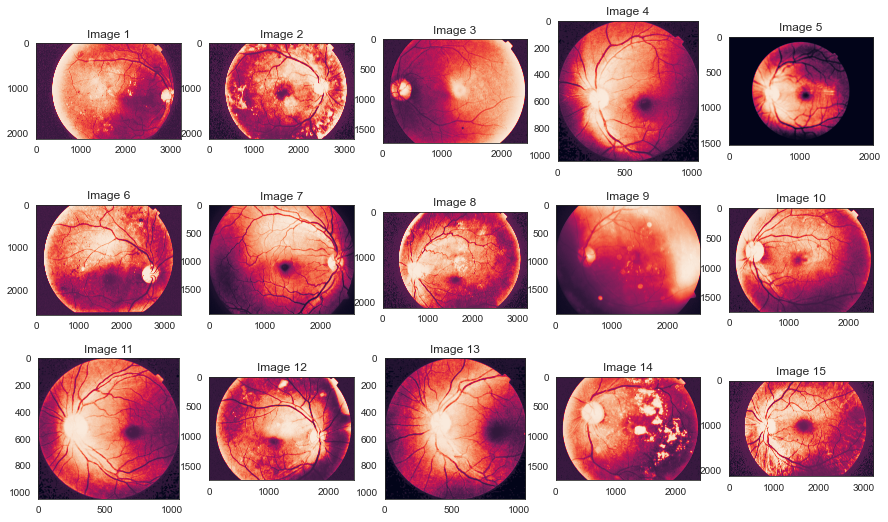

In [ ]:
import seaborn as sns
import cv2
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0,
	  tileGridSize=(8, 8))
    equalized = cv2.equalizeHist(img)
    plt.subplot(5, 5, count)
    plt.imshow(equalized)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [ ]:
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training',
    color_mode='rgb')

Found 2930 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation',
    color_mode='rgb')

Found 732 validated image filenames belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [ ]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
xvl, yvl = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer, Activation, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer(input_shape=[224,224,3]))

model.add(Conv2D(filters=16, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=20, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=5, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=3, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, strides=3, padding='same', activation='relu')) 

model.add(Flatten())

  # Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
  
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])
 



C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
his=model.fit(train_generator, 
          validation_data=valid_generator,
          steps_per_epoch=50, 
          epochs=100,
          )


Epoch 1/100
50/50 [==============================] - 134s 3s/step - loss: 1.3839 - acc: 0.4936 - val_loss: 1.3284 - val_acc: 0.4604
Epoch 2/100
50/50 [==============================] - 132s 3s/step - loss: 1.2811 - acc: 0.5100 - val_loss: 1.3089 - val_acc: 0.4604
Epoch 3/100
50/50 [==============================] - 130s 3s/step - loss: 1.2813 - acc: 0.5075 - val_loss: 1.3107 - val_acc: 0.4604
Epoch 4/100
50/50 [==============================] - 131s 3s/step - loss: 1.0870 - acc: 0.4938 - val_loss: 1.0595 - val_acc: 0.6325
Epoch 5/100
50/50 [==============================] - 131s 3s/step - loss: 1.0597 - acc: 0.6212 - val_loss: 1.0465 - val_acc: 0.6339
Epoch 6/100
50/50 [==============================] - 131s 3s/step - loss: 0.9096 - acc: 0.6975 - val_loss: 0.9353 - val_acc: 0.6708
Epoch 7/100
50/50 [==============================] - 131s 3s/step - loss: 0.8984 - acc: 0.6775 - val_loss: 0.9227 - val_acc: 0.6776
Epoch 8/100
50/50 [==============================] - 131s 3s/step - loss: 0.

In [ ]:
model.save('model/Moduul6/modelCNN.h5')

In [ ]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 75, 75, 16)        448       
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 1, 1, 32)          4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 1, 1, 32)          9248      
                                                                 
 average_pooling2d_6 (Averag  (None, 1, 1, 32)         0         
 ePooling2D)                                          

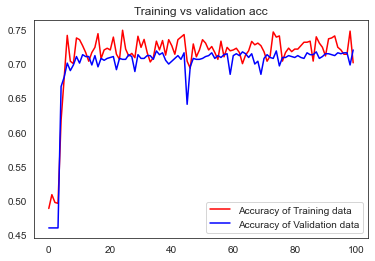

<Figure size 432x288 with 0 Axes>

In [ ]:
get_acc = his.history['acc']
value_acc = his.history['val_acc']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation acc')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
plt.savefig("model/Moduul6/modelCNNc.svg")

<Figure size 432x288 with 0 Axes>

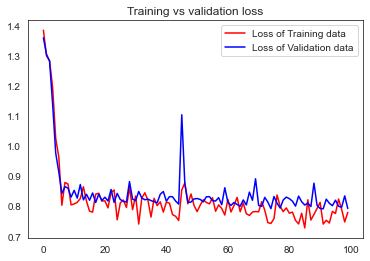

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
plt.savefig("model/Moduul6/modelCNN.svg")

<Figure size 432x288 with 0 Axes>

In [ ]:
# Simpan model dalam file Json
model_json = model.to_json()
with open("model/Moduul6/modelCNNlJson.json", "w") as json_file:
    json_file.write(model_json)
# Simpan bobot dalam file HDF5
model.save_weights("model/Moduul6/modelCNNh5.h5")

In [ ]:
# Convert the model.
converter1 = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model1 = converter1.convert()

# Save the model.
with open('model/Moduul6/modelCNN.tflite', 'wb') as f:
  f.write(tflite_model1)

INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpt671ku08\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpt671ku08\assets


In [ ]:
model.save('model/Moduul6/modelCNNh51.tflite')

INFO:tensorflow:Assets written to: model/Moduul6/modelCNNh51.tflite\assets


INFO:tensorflow:Assets written to: model/Moduul6/modelCNNh51.tflite\assets


In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet201

In [ ]:
base_model = DenseNet201(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
base_model2 = VGG19(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
base_model3 = ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
class Combin1:
  def build(base_model3,classes):
    headModel = base_model3.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation='relu')(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel

In [ ]:
headModel2 = Combin1.build(base_model3, 5)
model3 =Model(inputs=base_model3.input, outputs=headModel2)

In [ ]:

for layer in base_model3.layers:
  layer.trainable = False

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import SGD
model3.compile(
    optimizer=Adam(lr=0.00001, decay= 0.001/20),
    loss ='categorical_crossentropy',
    metrics =['accuracy']
)

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
test=model3.fit(
    train_generator,
     validation_data = valid_generator,
     epochs=100,
     steps_per_epoch= 50,
     batch_size=20,

)

Epoch 1/100
50/50 [==============================] - 216s 4s/step - loss: 1.3695 - accuracy: 0.4762 - val_loss: 1.3182 - val_accuracy: 0.4604
Epoch 2/100
50/50 [==============================] - 196s 4s/step - loss: 1.3449 - accuracy: 0.4427 - val_loss: 1.2563 - val_accuracy: 0.4617
Epoch 3/100
50/50 [==============================] - 190s 4s/step - loss: 1.2860 - accuracy: 0.5064 - val_loss: 1.2460 - val_accuracy: 0.4604
Epoch 4/100
50/50 [==============================] - 187s 4s/step - loss: 1.2049 - accuracy: 0.5288 - val_loss: 1.2300 - val_accuracy: 0.5246
Epoch 5/100
50/50 [==============================] - 188s 4s/step - loss: 1.1823 - accuracy: 0.5437 - val_loss: 1.2620 - val_accuracy: 0.4604
Epoch 6/100
50/50 [==============================] - 187s 4s/step - loss: 1.1748 - accuracy: 0.5487 - val_loss: 1.2040 - val_accuracy: 0.4604
Epoch 7/100
50/50 [==============================] - 189s 4s/step - loss: 1.1863 - accuracy: 0.5525 - val_loss: 1.1893 - val_accuracy: 0.4617
Epoch 

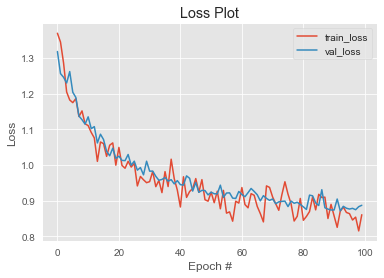

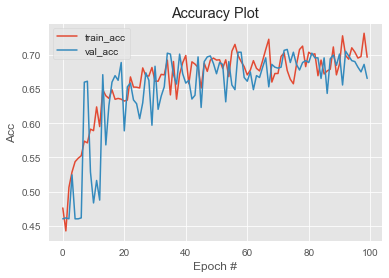

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), test.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), test.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
from keras.models import save_model
model_save = save_model(model3,'model/Moduul6/Resnet_1.h5')

In [ ]:
# Simpan model dalam file Json
model_json2 = model3.to_json()
with open("model/Moduul6/Resnet.json", "w") as json_file2:
    json_file2.write(model_json)
# Simpan bobot dalam file HDF5
model3.save_weights("model/Moduul6/Resnet.h5")

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model3.save('model/Moduul6/Resnet.tflite')

INFO:tensorflow:Assets written to: model/Moduul6/Resnet.tflite\assets


INFO:tensorflow:Assets written to: model/Moduul6/Resnet.tflite\assets
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the model.
with open('model/Moduul6/Resnet.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
base_model4 = MobileNet(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
class Combin3:
  def build(base_model1,classes):
    headModel = base_model1.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation='relu')(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel



In [ ]:
headModel4 = Combin3.build(base_model4, 5)
model5 =Model(inputs=base_model4.input, outputs=headModel4)

In [ ]:

for layer in base_model4.layers:
  layer.trainable = False

In [ ]:
model5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
from tensorflow.keras.optimizers import SGD
model5.compile(
    optimizer=Adam(lr=0.00001, decay= 0.001/20),
    loss ='categorical_crossentropy',
    metrics =['accuracy']
)

C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
test3=model5.fit(
    train_generator,
     validation_data = valid_generator,
     epochs=100,
     steps_per_epoch= 50,
     batch_size=20,

)

Epoch 1/100
50/50 [==============================] - 143s 3s/step - loss: 1.1922 - accuracy: 0.6062 - val_loss: 0.8594 - val_accuracy: 0.6899
Epoch 2/100
50/50 [==============================] - 144s 3s/step - loss: 0.8459 - accuracy: 0.7075 - val_loss: 0.7807 - val_accuracy: 0.7254
Epoch 3/100
50/50 [==============================] - 146s 3s/step - loss: 0.7268 - accuracy: 0.7387 - val_loss: 0.7235 - val_accuracy: 0.7432
Epoch 4/100
50/50 [==============================] - 141s 3s/step - loss: 0.6486 - accuracy: 0.7713 - val_loss: 0.7323 - val_accuracy: 0.7336
Epoch 5/100
50/50 [==============================] - 148s 3s/step - loss: 0.5718 - accuracy: 0.7850 - val_loss: 0.6899 - val_accuracy: 0.7623
Epoch 6/100
50/50 [==============================] - 152s 3s/step - loss: 0.5615 - accuracy: 0.8062 - val_loss: 0.6903 - val_accuracy: 0.7732
Epoch 7/100
50/50 [==============================] - 145s 3s/step - loss: 0.5219 - accuracy: 0.8263 - val_loss: 0.6611 - val_accuracy: 0.7678
Epoch 

In [ ]:
model5.save('model/Moduul6/modelmobile_1(1).h5')

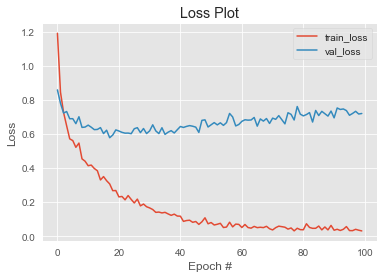

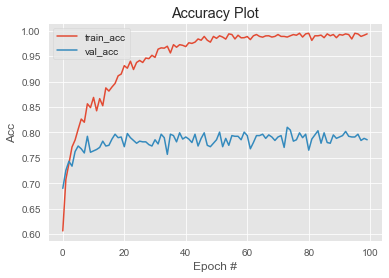

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test3.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), test3.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), test3.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), test3.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
plt.savefig("model/Moduul6/modelmobile.svg")

<Figure size 432x288 with 0 Axes>

In [ ]:
model_json2 = model5.to_json()
with open("model/Moduul6/modelmobile_1(1).json", "w") as json_file2:
    json_file2.write(model_json)
# Simpan bobot dalam file HDF5
model5.save_weights("model/Moduul6/modelmobile_1(1).h5")

In [ ]:
model5.save('model/Moduul6/modelmobile_1(1).tflite')

INFO:tensorflow:Assets written to: model/Moduul6/modelmobile_1(1).tflite\assets


INFO:tensorflow:Assets written to: model/Moduul6/modelmobile_1(1).tflite\assets


In [ ]:
converter3 = tf.lite.TFLiteConverter.from_keras_model(model5)
tflite_model3 = converter3.convert()

# Save the model.
with open('model/Moduul6/modelmobile_1(2).tflite', 'wb') as f:
  f.write(tflite_model3)

INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmp77158dqz\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmp77158dqz\assets


In [ ]:
model5.save('model/Moduul6/modelmobile_1(3).h5')